In [1]:
%matplotlib notebook
from glob import glob
from astropy.io import fits
import numpy as np
from ccdproc import ImageFileCollection
import matplotlib.pyplot as plt

plt.rc('text', usetex = True) # Use LaTeX font in plots
plt.rcParams['text.latex.preamble'] = r'\usepackage{gensymb}'

### 0.0. Verify all FITS headers, as some do not conform to standard.

This was a very frustrating step. On November 2 and 3, the FITS headers had two entries for LST and HA. This broke my normal file I/O code, which would have taken me a long time to rewrite. So, I wrote this small script to remove those parameters from the FITS headers for all of my files. Hopefully, this issue can be fixed at the telescope-level.

Also, I manually went in and changed all forward slashes in FITS filenames to periods.

In [2]:
def standardize_FITS(filepath):
    '''This function will remove two instances of the keywords LST and HA from 
    the headers of FITS files in the directory indicated by the filepath.'''
    all_filenames = glob(filepath, recursive=True)
    n = 0
    for filename in all_filenames:
        data, header = fits.getdata(filename, header=True)
        header.remove('LST', ignore_missing=True)
        header.remove('LST', ignore_missing=True) # Need to do this twice... because there's two of them
        header.remove('HA', ignore_missing=True)
        header.remove('HA', ignore_missing=True) # Need to do this twice... because there's two of them
        fits.writeto(filename, data, header, overwrite=True)
        n += 1
        print(n,"done")
    print("all done!")

In [3]:
# standardize_FITS('data/**/*.fits') # Standardize all FITS files for the project

### 0.1. Import CY Aqr frames, dark frames, and flat frames, excluding flagged bad frames.

In [4]:
directory_day1 = 'data/2020-10-26'
ic_cyaqr_day1 = ImageFileCollection(directory_day1, keywords='*', glob_include='CY_Aqr*', glob_exclude='*bad*')
ic_darks_day1 = ImageFileCollection(directory_day1, keywords='*', glob_include='dark*', glob_exclude='*bad*')
directory_day2 = 'data/2020-10-27'
ic_cyaqr_day2 = ImageFileCollection(directory_day2, keywords='*', glob_include='CY_Aqr*', glob_exclude='*bad*')
ic_darks_day2 = ImageFileCollection(directory_day2, keywords='*', glob_include='dark*', glob_exclude='*bad*')
ic_flats_day2 = ImageFileCollection(directory_day2, keywords='*', glob_include='flat*', glob_exclude='*bad*')
directory_day3 = 'data/2020-11-02'
ic_cyaqr_day3 = ImageFileCollection(directory_day3, keywords='*', glob_include='CY_Aqr*', glob_exclude='*bad*')
ic_darks_day3 = ImageFileCollection(directory_day3, keywords='*', glob_include='dark*', glob_exclude='*bad*')
ic_flats_day3 = ImageFileCollection(directory_day3, keywords='*', glob_include='flat*', glob_exclude='*bad*')
directory_day4 = 'data/2020-11-03'
ic_cyaqr_day4 = ImageFileCollection(directory_day4, keywords='*', glob_include='CY_Aqr*', glob_exclude='*bad*')
ic_darks_day4 = ImageFileCollection(directory_day4, keywords='*', glob_include='dark*', glob_exclude='*bad*')
ic_flats_day4 = ImageFileCollection(directory_day4, keywords='*', glob_include='flat*', glob_exclude='*bad*')

### 0.2. Reduce the data.

First, I'll produce **final dark frames** for each science and flat exposure time.

In [5]:
def make_final_dark(ic_files, directory):
    '''Pass this function some dark frames from an image collection
    and it will create a final dark frame.'''
    lst = []
    for i in range(len(ic_files)):
        lst.append(fits.getdata(directory+'/'+ic_files[i]))
    arr = np.array(lst)
    final_dark = np.median(arr, axis=0)
    return final_dark

In [6]:
final_dark_15s_day1_day2 = make_final_dark(ic_darks_day1.files_filtered(exptime=15), directory_day1)
final_dark_5s_day1_day2 = make_final_dark(ic_darks_day2.files_filtered(exptime=5), directory_day2)
final_dark_15s_day3 = make_final_dark(ic_darks_day3.files_filtered(exptime=15), directory_day3)
final_dark_2s_day3 = make_final_dark(ic_darks_day3.files_filtered(exptime=2), directory_day3)
final_dark_15s_day4 = make_final_dark(ic_darks_day4.files_filtered(exptime=15), directory_day4)
final_dark_2s_day4 = make_final_dark(ic_darks_day4.files_filtered(exptime=2), directory_day4)

Then, I'll produce **normalized final flat frames** for each filter (only V band).

In [7]:
def make_norm_final_flat(ic_files, directory, final_dark):
    '''Pass this function some flat frames and a final dark frame
    and it will create a normalized final flat field image.'''
    lst = []
    for i in range(len(ic_files)):
        lst.append(fits.getdata(directory+'/'+ic_files[i]))
    arr = np.array(lst)
    median_combined_flat = np.median(arr, axis=0)
    final_flat = median_combined_flat - final_dark # These should have the same exposure time
    norm_final_flat = final_flat/np.nanmedian(final_flat)
    return norm_final_flat

In [8]:
norm_final_flat_day1_day2 = make_norm_final_flat(ic_flats_day2.files_filtered(exptime=5), 
                                                 directory_day2, 
                                                 final_dark_5s_day1_day2)
norm_final_flat_day3 = make_norm_final_flat(ic_flats_day3.files_filtered(exptime=2), 
                                            directory_day3, 
                                            final_dark_2s_day3)
norm_final_flat_day4 = make_norm_final_flat(ic_flats_day4.files_filtered(exptime=2), 
                                            directory_day4, 
                                            final_dark_2s_day4)

Now, I will perform dark-subtraction and flat-field-correction on our science frames in the V band. Since we are only working with a single exposure time, this process is simplified. First, I'll dark-subtract each individual science frame using the **final dark frame** with the correct exposure time. I'll also keep the time of the observation linked with  each science frame.

In [9]:
def get_star_images_times(ic_files, directory):
    '''Pass this function an ImageCollection of files and the directory 
    they come from to get arrays containing the frames and observation times.'''
    frames = []
    times = []
    for i in range(len(ic_files)):
        frame = fits.getdata(directory+'/'+ic_files[i])
        frames.append(frame)
        hdr = fits.getheader(directory+'/'+ic_files[i])
        times.append(hdr['DATE-OBS'])
    frames_arr = np.array(frames)
    times_arr = np.array(times)
    return frames_arr, times_arr

In [10]:
# Extract images of stars as well as observation times
cyaqr_im_day1, cyaqr_tm_day1 = get_star_images_times(ic_cyaqr_day1.files_filtered(exptime=15), directory_day1)
cyaqr_im_day2, cyaqr_tm_day2 = get_star_images_times(ic_cyaqr_day2.files_filtered(exptime=15), directory_day2)
cyaqr_im_day3, cyaqr_tm_day3 = get_star_images_times(ic_cyaqr_day3.files_filtered(exptime=15), directory_day3)
cyaqr_im_day4, cyaqr_tm_day4 = get_star_images_times(ic_cyaqr_day4.files_filtered(exptime=15), directory_day4)

In [11]:
# Use array broadcasting to dark-subtract appropriate dark frames from each science frame
cyaqr_im_day1_d = cyaqr_im_day1 - final_dark_15s_day1_day2[np.newaxis,:,:] # Use array brdcstng to dark-subtract
cyaqr_im_day2_d = cyaqr_im_day2 - final_dark_15s_day1_day2[np.newaxis,:,:] # Use array brdcstng to dark-subtract
cyaqr_im_day3_d = cyaqr_im_day3 - final_dark_15s_day3[np.newaxis,:,:] # Use array brdcstng to dark-subtract
cyaqr_im_day4_d = cyaqr_im_day4 - final_dark_15s_day4[np.newaxis,:,:] # Use array brdcstng to dark-subtract

Then, I'll flat-field correct each individual science frame using the **final flat frame** for the correct filter.

In [12]:
cyaqr_im_day1_d_f = cyaqr_im_day1_d/norm_final_flat_day1_day2[np.newaxis,:,:] # Arr brdcstng to flat-field correct
cyaqr_im_day2_d_f = cyaqr_im_day2_d/norm_final_flat_day1_day2[np.newaxis,:,:] # Arr brdcstng to flat-field correct
cyaqr_im_day3_d_f = cyaqr_im_day3_d/norm_final_flat_day3[np.newaxis,:,:] # Arr brdcstng to flat-field correct
cyaqr_im_day4_d_f = cyaqr_im_day4_d/norm_final_flat_day4[np.newaxis,:,:] # Arr brdcstng to flat-field correct

### 1.0. Perform aperture photometry on CY Aqr in each image.

Here, I will perform aperture photometry on CY Aqr in each image in our dataset for days 3 and 4. I use hard-coded masks to search for the star in a certain area of the image for each day, because I did not align the images. I will only record instrumental magnitudes from stars which are successfully fit by the algorithm.

In [13]:
from astropy.stats import sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import DAOStarFinder, CircularAperture

In [14]:
def plot_peaks(image, sources, mean, std):
    '''This function will plot the location of sources in an image.'''
    positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) # Get positions for plotting
    apertures = CircularAperture(positions, r=4.) # Create apertures for plotting
    norm = ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=mean+10.*std) # Create normalization for plotting
    plt.figure(dpi = 100) # Initialize a figure, so it's bigger
    plt.imshow(image, origin='lower', norm=norm, interpolation='nearest') # Show location of the source
    apertures.plot(color='blue', lw=1.5, alpha=0.5)
    plt.show()

In [15]:
def aperture_photometry_masked(frames, times, day):
    '''Pass this function a collection of image frames and it will find 
    CY Aqr in each image and do aperture photometry on it, returning a 
    list of instrumental magnitudes and observation times for only the 
    frames it was able to fit. This function also requires specification
    of which day the frames are from, as the mask for where to search for
    peaks changes day by day.'''
    mask = np.ones(frames[0].shape, dtype=bool) # Begin creating the mask for where to search for CY Aqr
    # Nota bene: I am using the mask backwards from how I think they designed it, as many
    # examples start by initializing a mask full of Falses and making some values True
    if day == 3:
        mask[450:750,300:700] = False # Only search in this area, but remember: y, then x
    if day == 4:
        mask[100:750,300:1000] = False # Only search in this area, but remember: y, then x
    cyaqr_inst_mags = [] # Initialize list for magnitudes
    cyaqr_good_times = [] # Initialize list for good times
    index = 0
    good_frame_count = 0
    for image in frames:
        mean, median, std = sigma_clipped_stats(image, sigma=3.0) # Calculate sigma-clipped statistics on image 
        # Now, create a finder with a threshold value to search above and a FWHM to use, 
        # and make sure to only grab the brightest source
        starfinder = DAOStarFinder(threshold=10.0*std, fwhm=6, exclude_border=True, brightest=1)
        sources = starfinder(image, mask=mask) # Search for stars using the finder and mask
        if sources is not None: # If a peak is found
#             print("Good frame",good_frame_count) # Display which frame in the final array this is
#             plot_peaks(image, sources, mean, std) # Plot the location of the peak
            counts_per_second = sources['flux']*(1.0/15.0) # Divide by the exposure time
            m_inst = -2.5*np.log10(counts_per_second)
            cyaqr_inst_mags.append(m_inst) # Record the magnitude of the source
            cyaqr_good_times.append(times[index]) # Record the corresponding time
            good_frame_count += 1
        index += 1
    return cyaqr_inst_mags, cyaqr_good_times

In [16]:
# Perform aperture photometry; sorry about all the warnings for failed frames
inst_mags_day3, kept_times_day3 = aperture_photometry_masked(cyaqr_im_day3_d_f, cyaqr_tm_day3, 3)
inst_mags_day4, kept_times_day4 = aperture_photometry_masked(cyaqr_im_day4_d_f, cyaqr_tm_day4, 4)

After inspecting the images by eye, I will remove frames that either don't contribute to the light curve (for the beginning of day 3) or where `DAOStarFinder` found a peak that was not CY Aqr (both days).

In [17]:
# Remove the non-CY Aqr peaks from each night, making sure to move from highest index number to lowest
# Only need to run these once after the photometry has been done
rem_bad_indices_day3 = np.concatenate((np.arange(0,21),np.array([158, 181, 208, 243])))
for index in sorted(rem_bad_indices_day3, reverse=True): # Highest to lowest index
    del inst_mags_day3[index]
    del kept_times_day3[index]
rem_bad_indices_day4 = np.array([202])
for index in sorted(rem_bad_indices_day4, reverse=True): # Highest to lowest index
    del inst_mags_day4[index]
    del kept_times_day4[index]
inst_mags_day3 = np.array(inst_mags_day3)
kept_times_day3 = np.array(kept_times_day3)
inst_mags_day4 = np.array(inst_mags_day4)
kept_times_day4 = np.array(kept_times_day4)

In [18]:
# Let's see how many images we're left with!
print(len(inst_mags_day3),"images from day 3")
print(len(inst_mags_day4),"images from day 4")
print(len(inst_mags_day3)+len(inst_mags_day4),"images total")

244 images from day 3
250 images from day 4
494 images total


In [19]:
def convert_mag_inst_app(inst_mags):
    '''Convert from instrumental magnitudes to apparent magnitudes using my 
    zero point for the RHO setup as measured in the photometry homework.'''
    app_mags = inst_mags + 20.96 # Add zero point
    return(app_mags)

In [20]:
# Remove extra dimension (each value is its own array)
inst_mags_day3 = inst_mags_day3.flatten()
inst_mags_day4 = inst_mags_day4.flatten()
kept_times_day3 = kept_times_day3.flatten()
kept_times_day4 = kept_times_day4.flatten()
# Convert to apparent magnitude
app_mags_day3 = convert_mag_inst_app(inst_mags_day3)
app_mags_day4 = convert_mag_inst_app(inst_mags_day4)

### 2.0. Create a light curve of the apparent magnitude of CY Aqr over time.

If I had more time, I'd make the non-filtered and filtered light curves into subplots.

In [21]:
from astropy.time import Time, TimeDelta
from astropy.timeseries import TimeSeries
from scipy.ndimage import median_filter

<IPython.core.display.Javascript object>


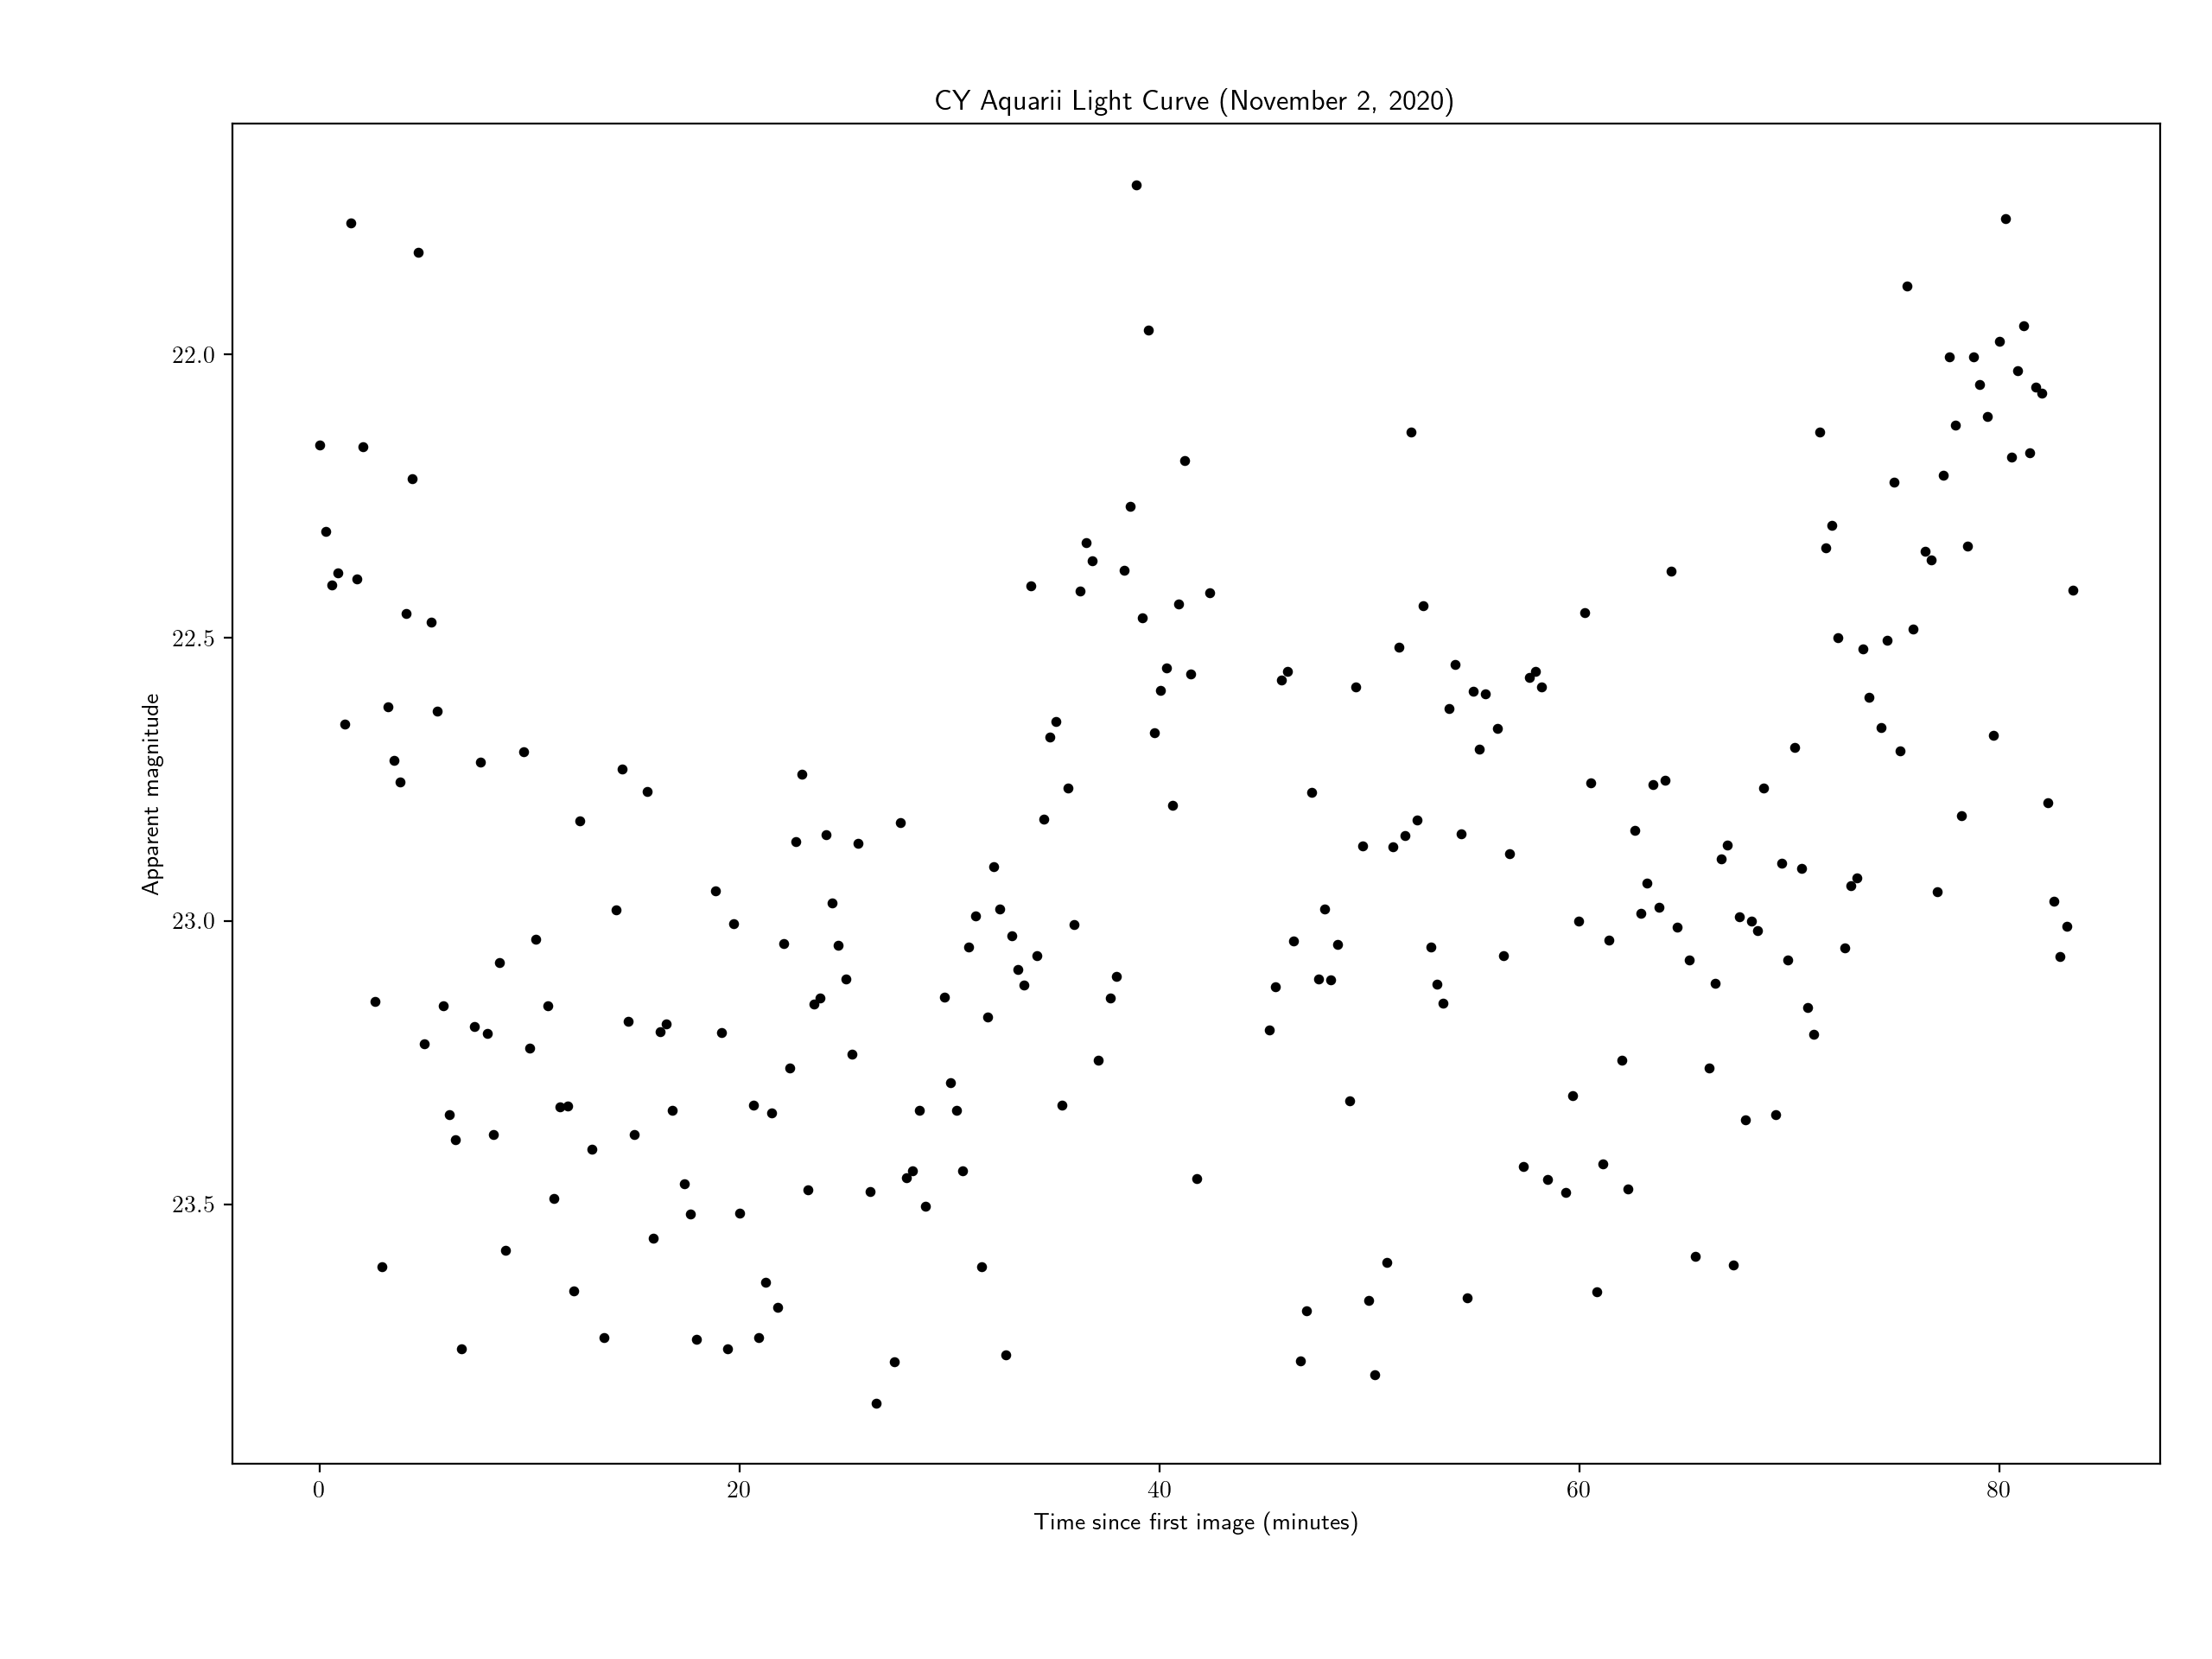

In [22]:
ts_day3 = TimeSeries(time=kept_times_day3)
ts_rel_day3 = TimeSeries(time=ts_day3.time - ts_day3.time[0])
ts_rel_day3_min = ts_rel_day3.time.to('minute')

plt.figure(dpi = 100)
plt.scatter(ts_rel_day3_min, app_mags_day3, s=10, c='k')
plt.gca().invert_yaxis()
plt.title("CY Aquarii Light Curve (November 2, 2020)")
plt.ylabel("Apparent magnitude")
plt.xlabel("Time since first image (minutes)")
plt.tight_layout()
plt.savefig("lightcurve_day3.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()

<IPython.core.display.Javascript object>


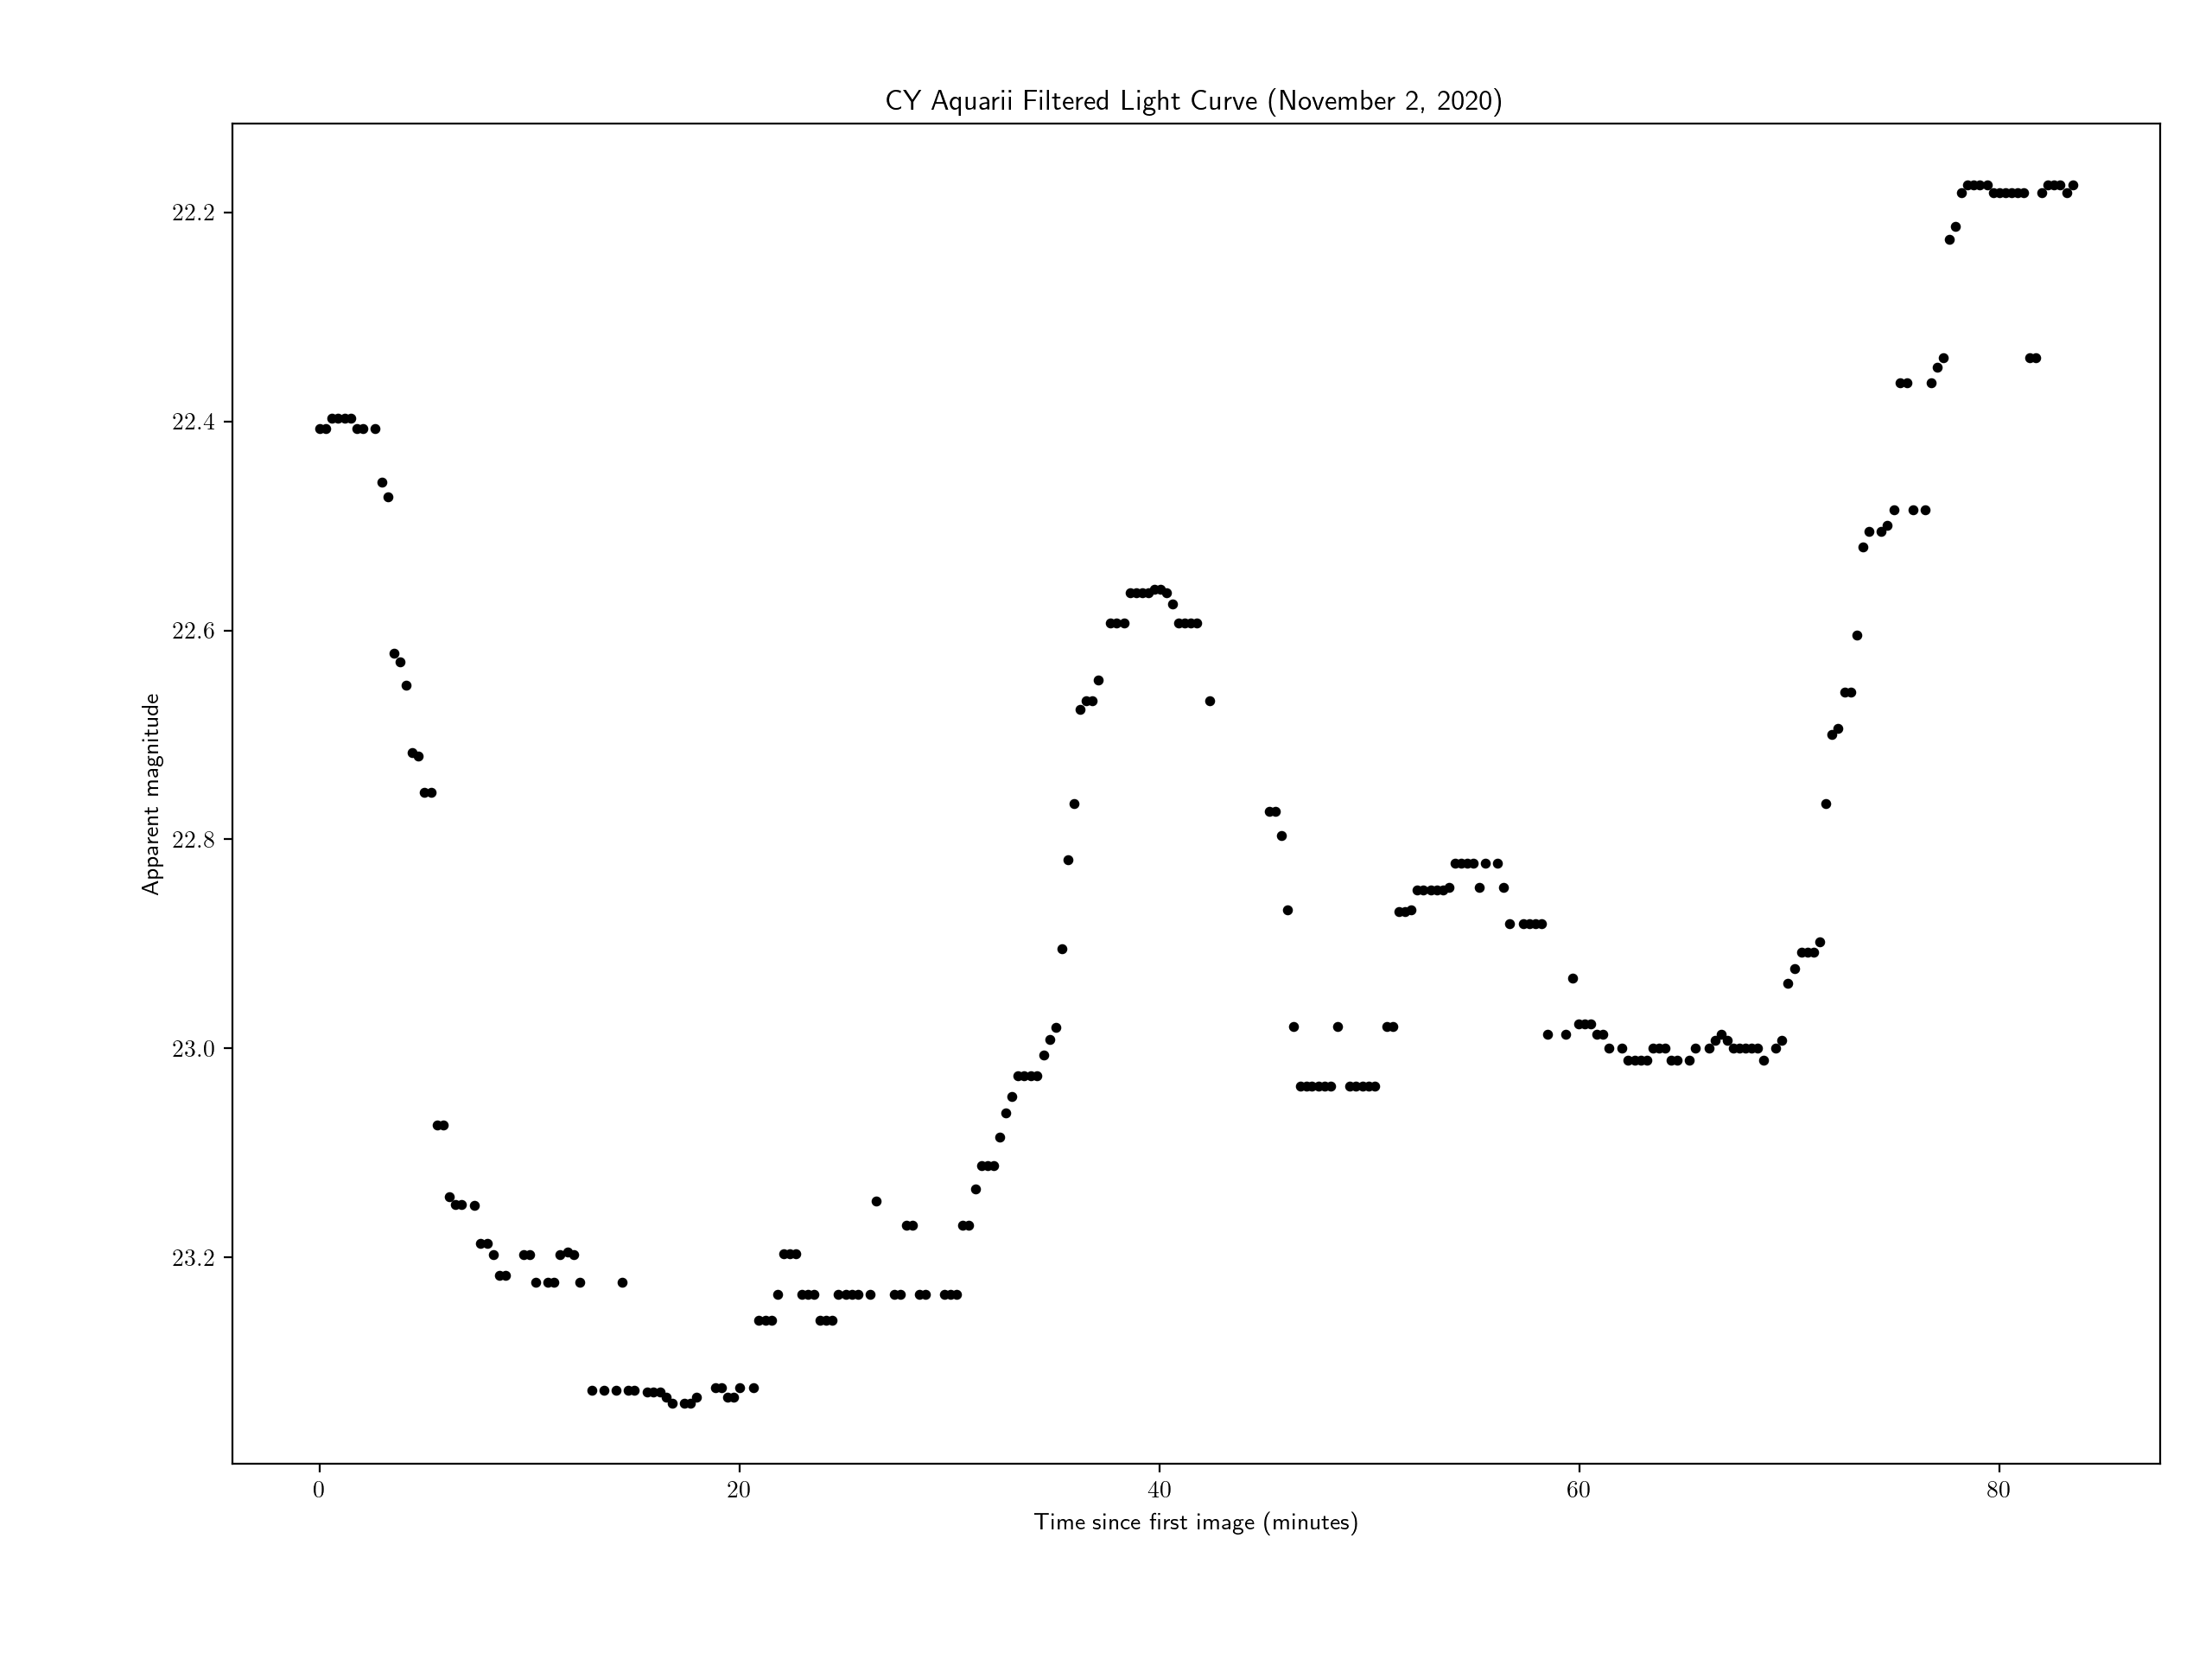

In [23]:
app_mags_day3_filt = median_filter(app_mags_day3, size=25)

plt.figure(dpi = 100)
plt.scatter(ts_rel_day3_min, app_mags_day3_filt, s=10, c='k')
plt.gca().invert_yaxis()
plt.title("CY Aquarii Filtered Light Curve (November 2, 2020)")
plt.ylabel("Apparent magnitude")
plt.xlabel("Time since first image (minutes)")
plt.tight_layout()
plt.savefig("lightcurve_filt_day3.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()

<IPython.core.display.Javascript object>


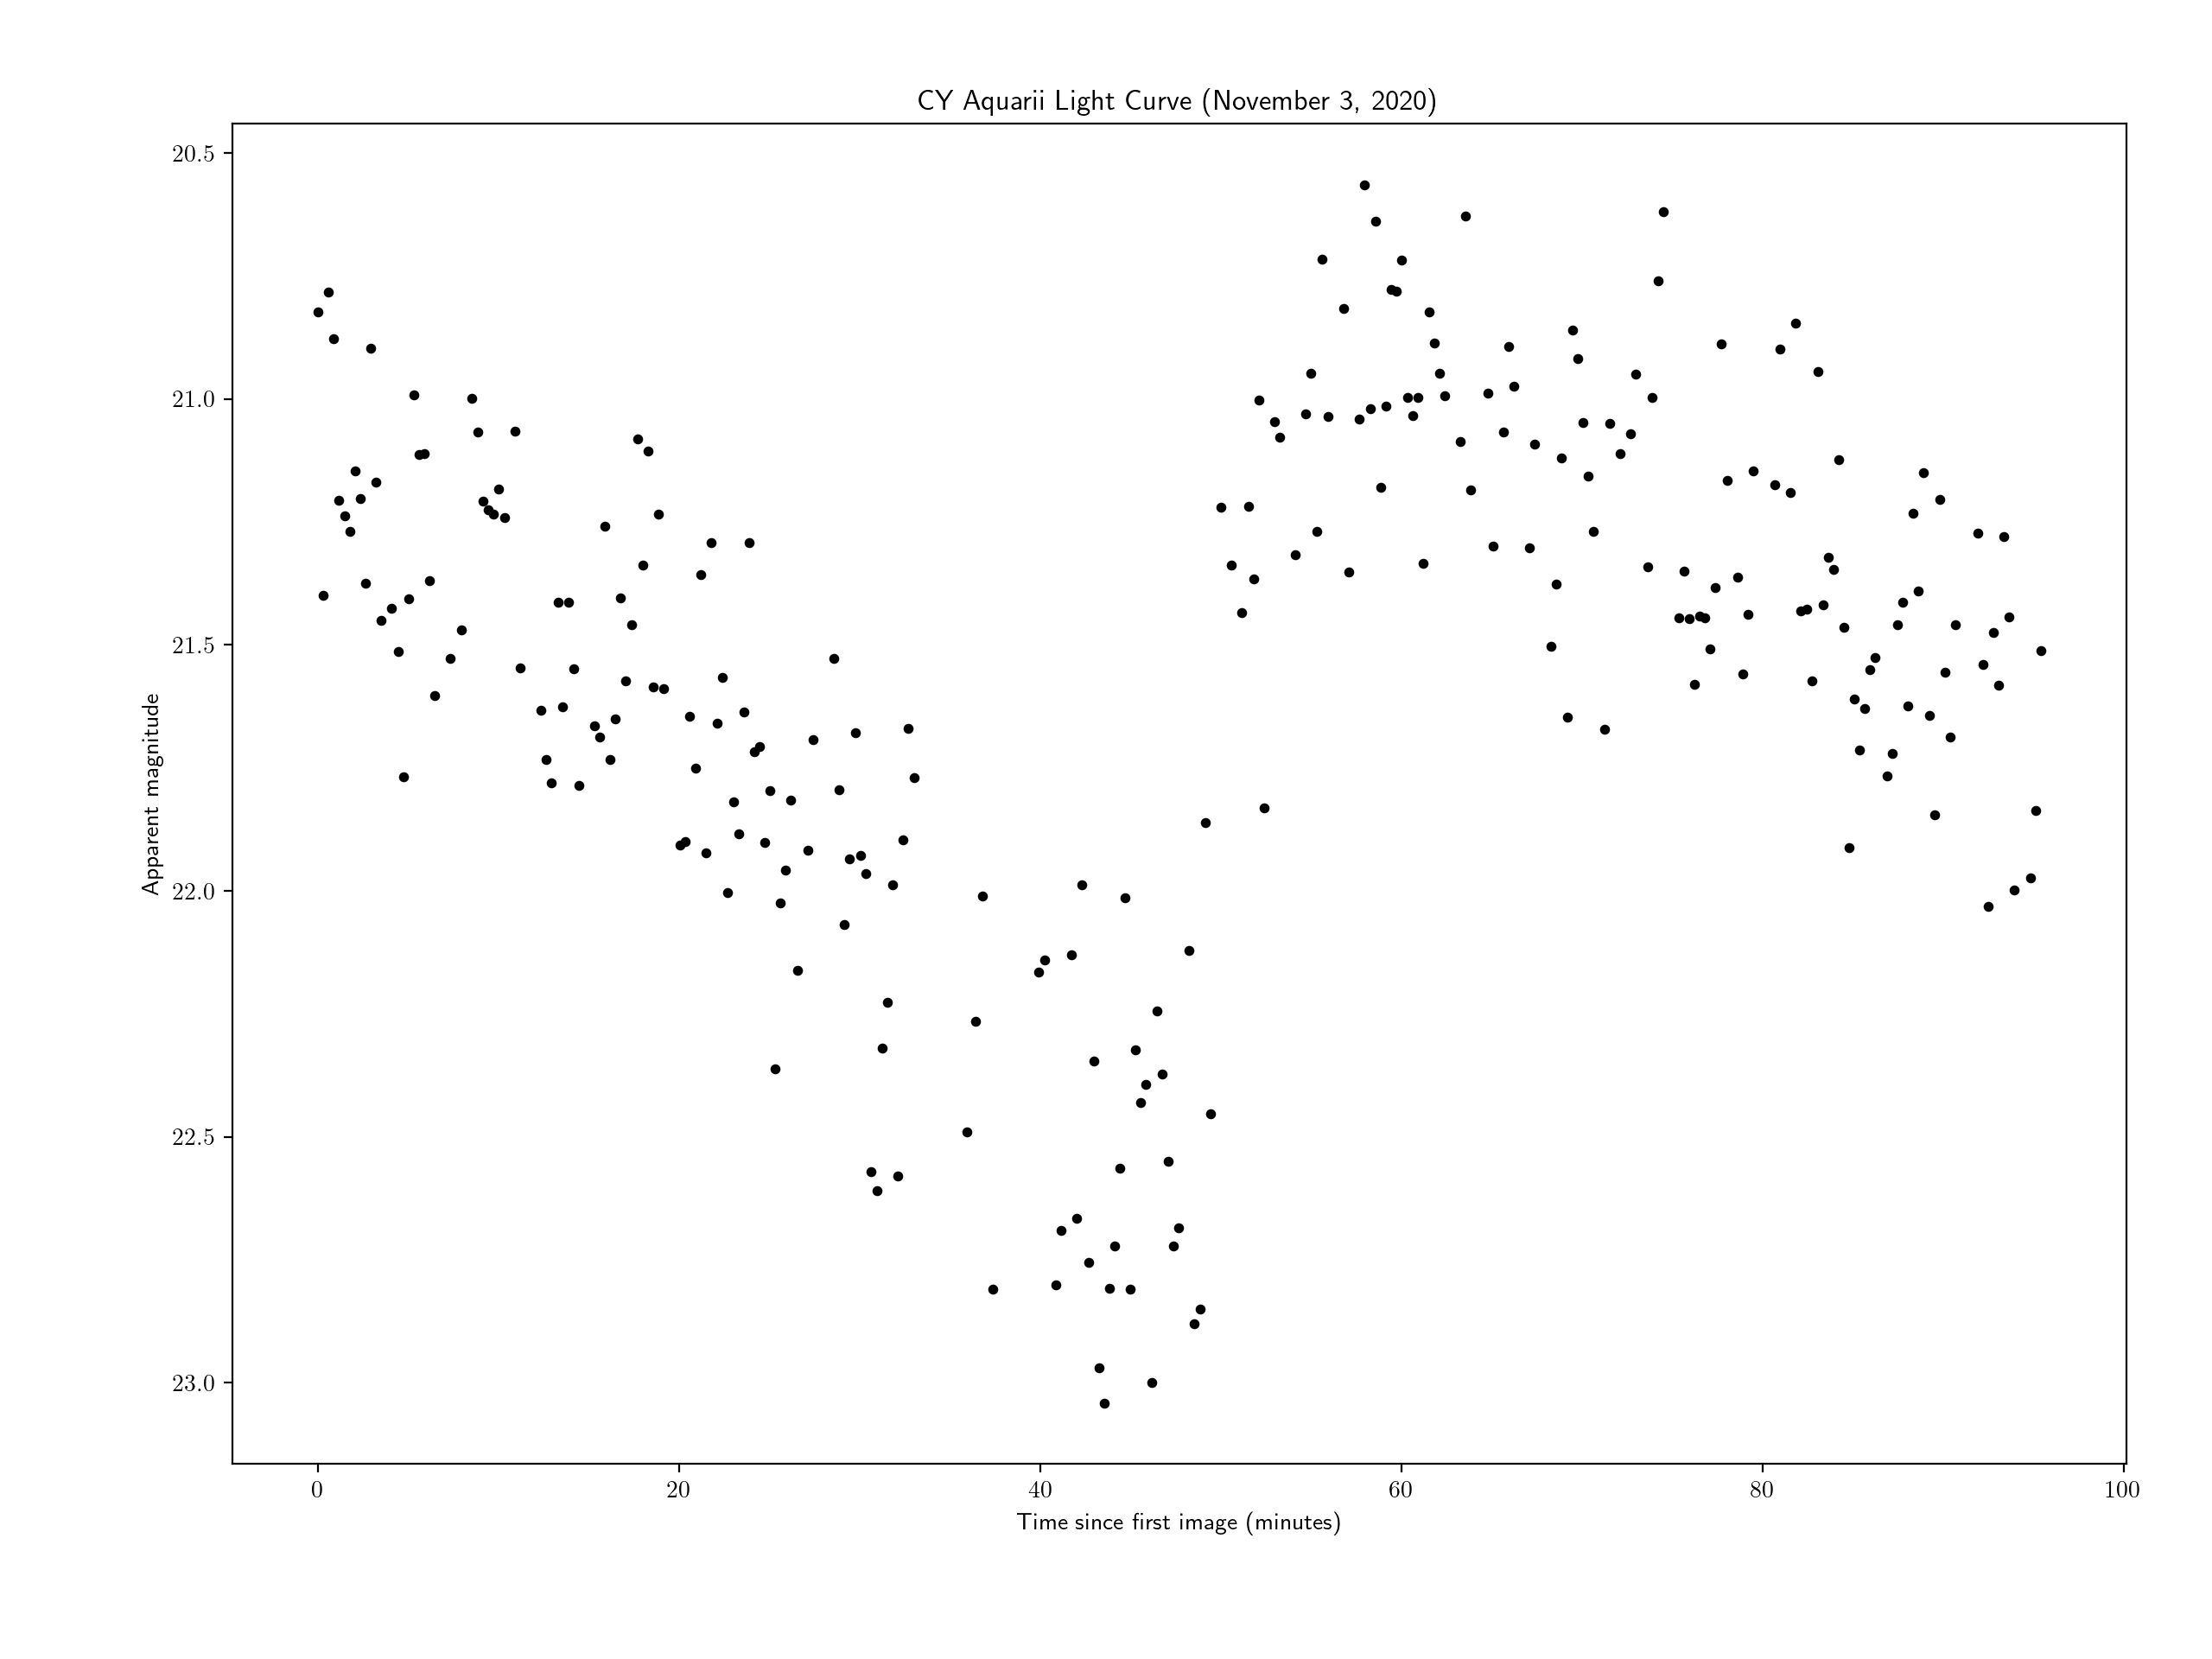

In [24]:
ts_day4 = TimeSeries(time=kept_times_day4)
ts_rel_day4 = TimeSeries(time=ts_day4.time - ts_day4.time[0])
ts_rel_day4_min = ts_rel_day4.time.to('minute')

plt.figure(dpi = 100)
plt.scatter(ts_rel_day4_min, app_mags_day4, s=10, c='k')
plt.gca().invert_yaxis()
plt.title("CY Aquarii Light Curve (November 3, 2020)")
plt.ylabel("Apparent magnitude")
plt.xlabel("Time since first image (minutes)")
plt.tight_layout()
plt.savefig("lightcurve_day4.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()

<IPython.core.display.Javascript object>


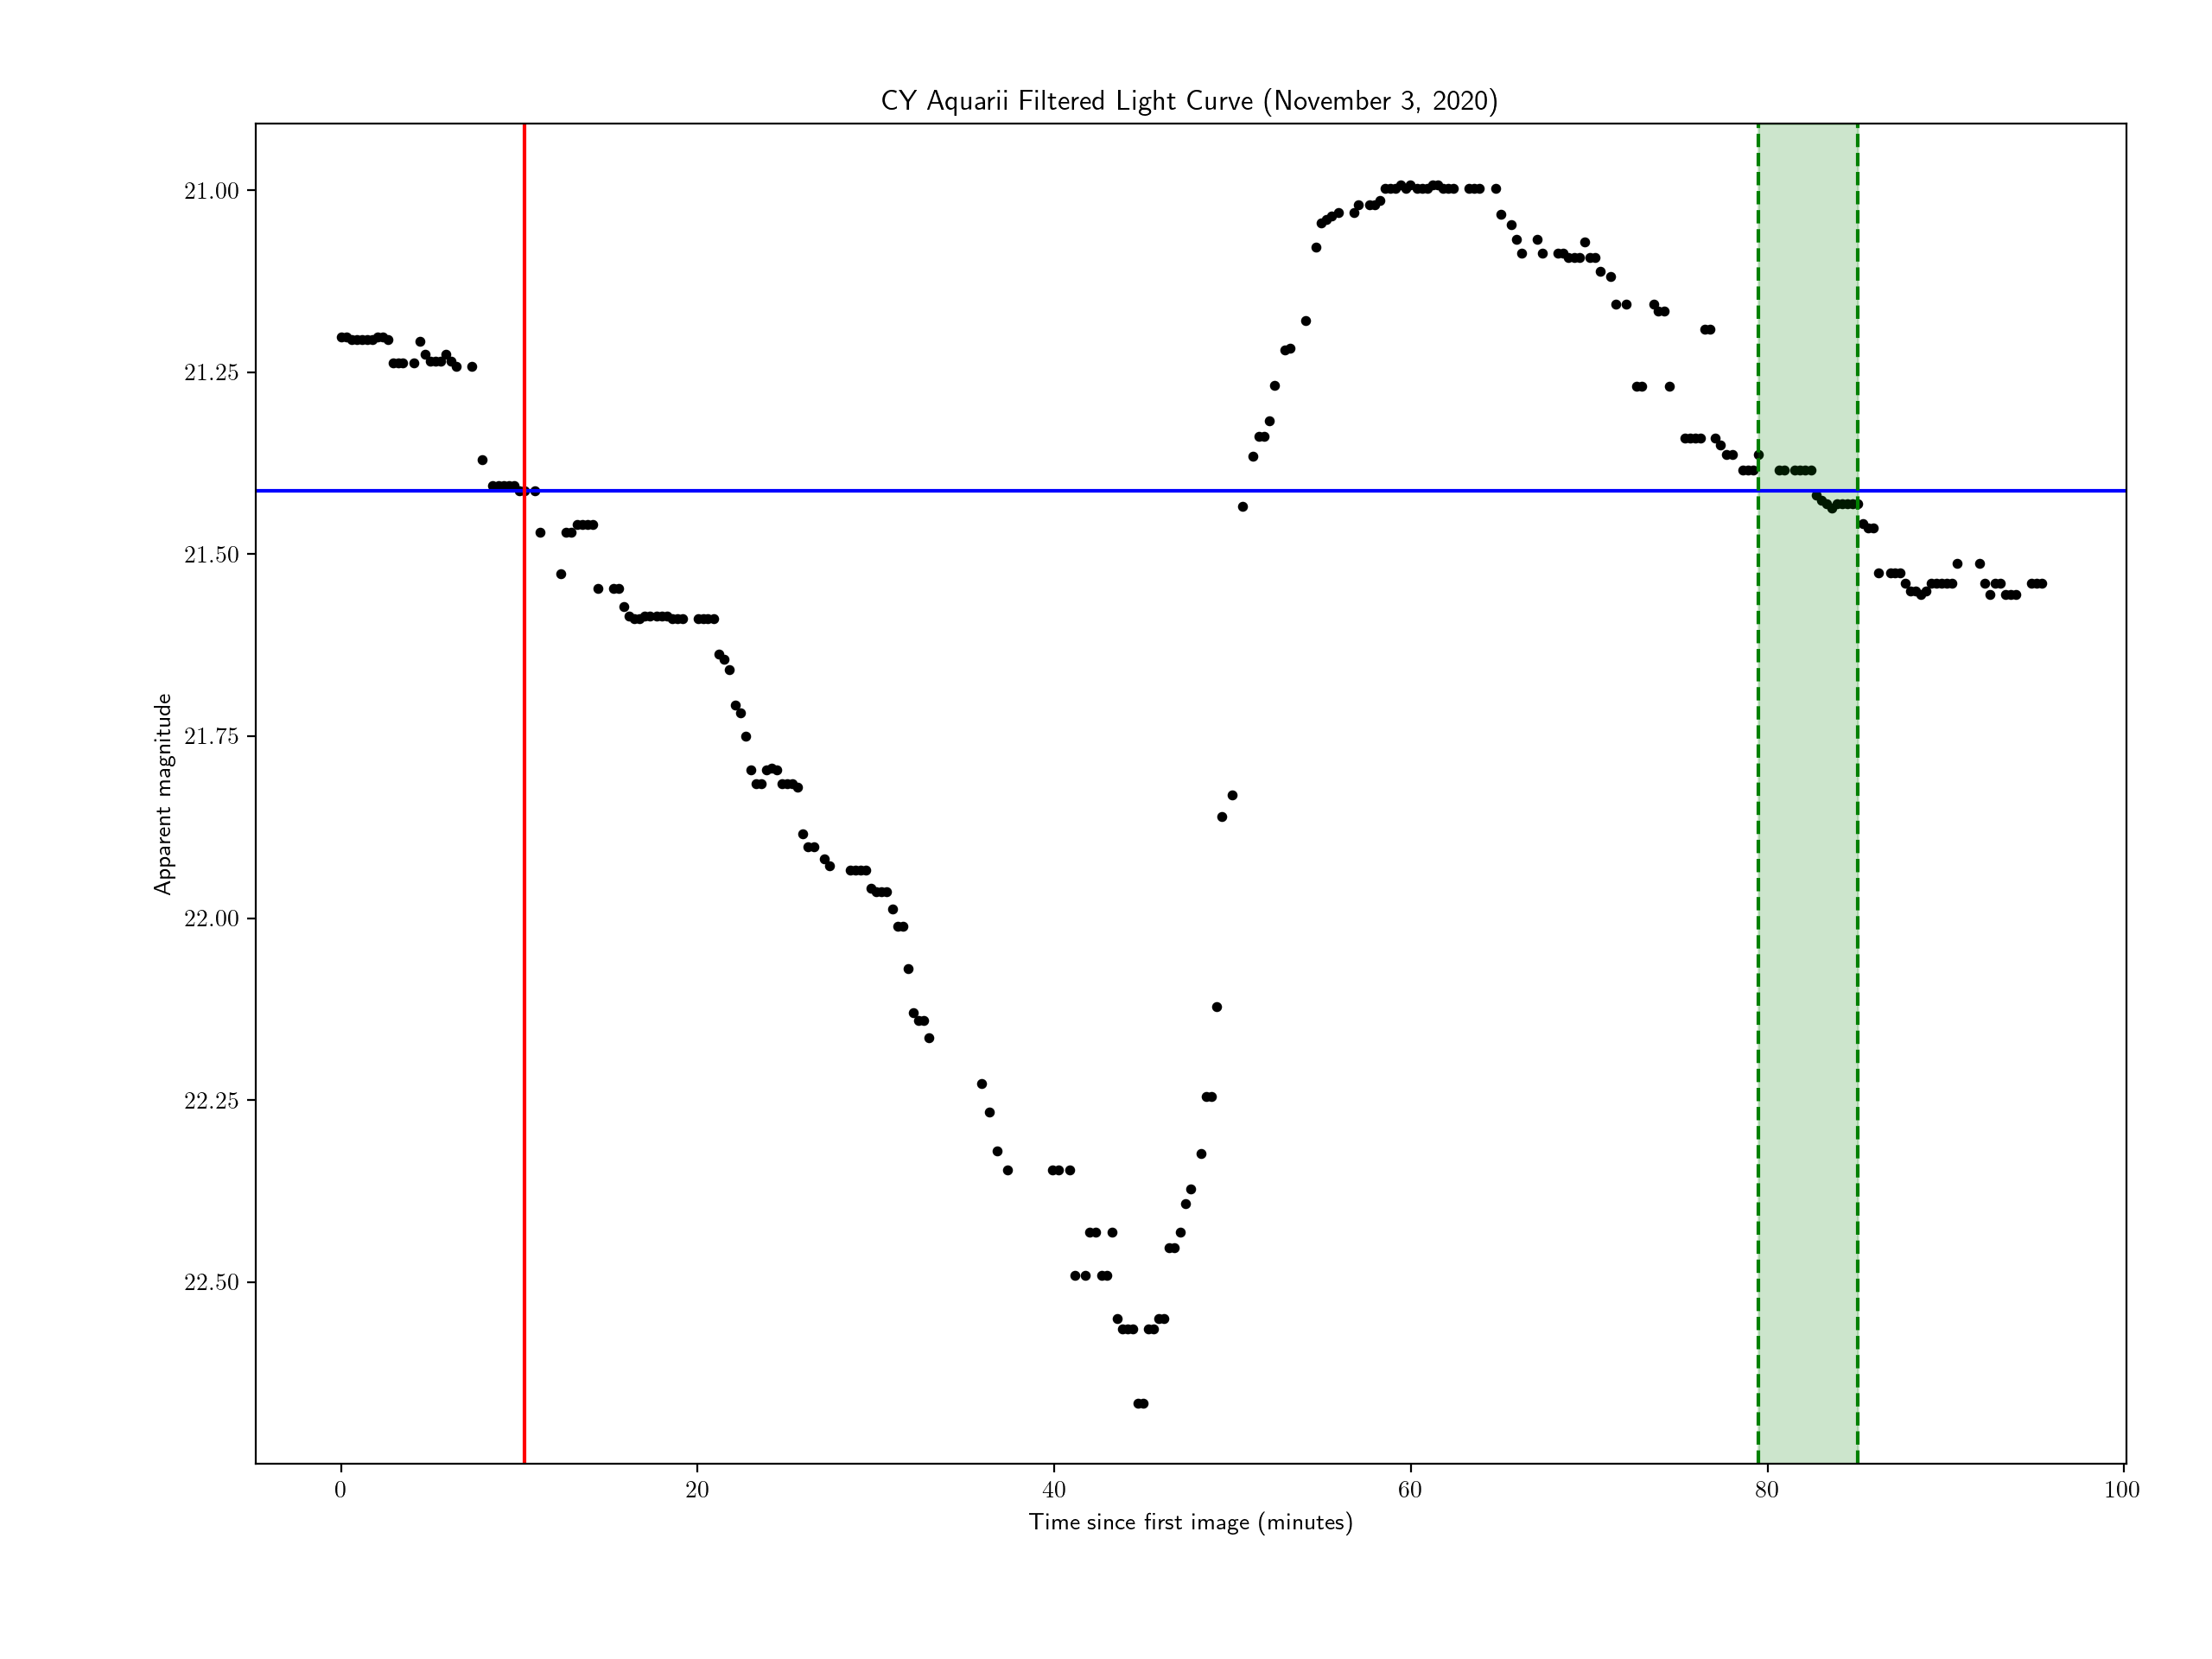

In [25]:
app_mags_day4_filt = median_filter(app_mags_day4, size=25)

plt.figure(dpi = 100)
plt.scatter(ts_rel_day4_min, app_mags_day4_filt, s=10, c='k')
plt.axhline(app_mags_day4_filt[30], c='b')
plt.axvline(np.array(ts_rel_day4_min)[30], c='r')
plt.axvline(np.array(ts_rel_day4_min)[205], c='g', ls='--')
plt.axvline(np.array(ts_rel_day4_min)[220], c='g', ls='--')
plt.axvspan(np.array(ts_rel_day4_min)[205], np.array(ts_rel_day4_min)[220], alpha=0.2, color='g')
plt.gca().invert_yaxis()
plt.title("CY Aquarii Filtered Light Curve (November 3, 2020)")
plt.ylabel("Apparent magnitude")
plt.xlabel("Time since first image (minutes)")
plt.tight_layout()
plt.savefig("lightcurve_filt_day4.png", dpi=250, facecolor='w', edgecolor='w')
plt.show()

In [26]:
# Estimate brightness variation from day 4 apparent magnitudes
print(round(np.mean(app_mags_day4[137:180])))
# print()
print(round(np.mean(app_mags_day4[134:184]) - np.mean(app_mags_day4[102:125]),1))
print(len(app_mags_day4))

21
-1.5
250


In [27]:
# Estimate period by eye
print("First point:",ts_rel_day4_min[30])
print("Possible second points:",ts_rel_day4_min[205],"to",ts_rel_day4_min[220])
period_small = ts_rel_day4_min[205] - ts_rel_day4_min[30]
period_large = ts_rel_day4_min[220] - ts_rel_day4_min[30]
print("Estimate of period is between",period_small,"and",period_large)

First point: 10.294483333333329 min
Possible second points: 79.47858333333345 min to 85.06716666666676 min
Estimate of period is between 69.18410000000011 min and 74.77268333333343 min


In [28]:
# Estimate average apparent magnitude from day 4 light curve
print(np.mean(app_mags_day4))

21.550334522689162
